# `Projet 7 : Implementez un modèle de scoring`

**Notebook Traitement et nettoyage des données**

Ce notebook est destinée au traitement et nettoyage des données rassemblés selon le notebook P7_n1 

Les étapes : 

- 1er Partie: Mise en Place et Installation des bibliotheques necessaires

- 2ème Partie: Telechargement des fichiers 

- 3ème Partie: Analyse Exploratoire des données

- 4ème Partie: Nettoyage des données

- 5ème Partie : Sauvegarde des données. 

# `1er Partie: Mise en place et Installation de l'environnement`

---

Avec la :
- Instalation de libraries utiles à l'acquisition de la données ainsi que les différents traitements statistiques et visualisation nécessaire dans un premier temps (Pandas & Numpy)
- Confirmation et changement de "directory si necessaire avec os.getwd()
- Amélioration d'options d'affichage avec 'pd.set_option'

In [ ]:
# Outils mathématiques et manipulation de données
import pandas as pd
import numpy as np
import scipy as sp


# Librairies graphiques
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import seaborn as sns
from textwrap import wrap

# Cross-validation et hyperparamétrisation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold

# Transformateurs de variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# Librairie de Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# Metriques de Segmentation
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix

# Réduction de dimensions
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV

# Création de pipelines
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

In [ ]:
#savoir où est mon "directory"
import os
os.getcwd()

'/content'

In [ ]:
# Changer 'directory' sur google lab:
# 1st of all: connect to google drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Options d'affichage des outputs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
sns.color_palette("rocket") # choix de la palette de couleurs sns

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [ ]:
#pallette de couleurs :
colors = sns.color_palette("rocket")

In [ ]:
%pwd

'/content'

In [ ]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

# `2ème Partie: Telechargement`


On telecharge les données que nous avons auparavant rassemnlé.

In [ ]:
### Importation des données rassemblés sur notebook 1 (P7_n1_Merging_Datasets)

import dill

with open('drive/My Drive/Projet_7/dict_df_agg.pkl', 'rb') as file:
    dict_agg = dill.load(file)

In [ ]:
X_train = dict_agg['X_train']
y_train = dict_agg['y_train']
X_test = dict_agg['X_test']

In [ ]:
X_train.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       ...
       'PA_OUTSTANDING_LOAN__sum', 'PA_OUTSTANDING_LOAN__size', 'PA_AMT_DIFF_PCT__mean',
       'PA_AMT_DIFF_PCT__max', 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON',
       'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'CNT_FAM_MEMBERS_NOT_CHILD'],
      dtype='object', length=228)

In [ ]:
y_train

,TARGET
SK_ID_CURR,
100002,1
100003,0
100004,0
100006,0
100007,0
...,...
456251,0
456252,0
456253,0


# `3ème Partie: Analyse Exploratoire des données`

`Checker le shape des données `

In [ ]:
#telecharger données avant pour comparer

d_teste = pd.read_csv("drive/My Drive/Projet_7/database/application_test.csv")
d_train = pd.read_csv("drive/My Drive/Projet_7/database/application_train.csv")

# Comparer avec la base de données originales  (228 - 121 = 107 variables crées.)
print( "données entrainement: ", X_train.shape, d_train.shape, "\n","données test:", X_test.shape, d_teste.shape)


données entrainement:  (307511, 228) (307511, 122) 
 données test: (48744, 228) (48744, 121)


### `Checker les 'data unbalanced'`

TARGET avec valeur egal à 0 = prêt a été payé, TARGET=1 prêt pas payé. 

In [ ]:
y_train.value_counts()

TARGET
0         282686
1          24825
dtype: int64

In [ ]:
temp = y_train["TARGET"].value_counts()
target_df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

In [ ]:
target_df

,labels,values
0,0,282686
1,1,24825


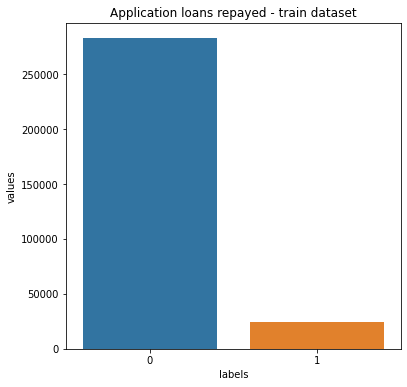

In [ ]:
plt.figure(figsize = (6,6))
plt.title('Application loans repayed - train dataset')
sns.set_color_codes('pastel')
sns.barplot(x = 'labels', y="values", data=target_df)
locs, labels = plt.xticks()
plt.show()

# Les données sont visiblement unballanced

`Types de variables `

In [ ]:
# features types

X_train.dtypes.value_counts()

float64    173
int64       39
object      16
dtype: int64

In [ ]:
# getting categorical and quantitative columns

cat_cols = X_train.select_dtypes(exclude=[np.number]).columns
quant_cols = X_train.select_dtypes(include=[np.number]).columns

bin_cols = X_train.columns[X_train.nunique()==2]
int_cols = \
    [c for c in X_train.select_dtypes(include=['int']).columns \
                                                if c not in bin_cols]
f64_cols = \
    [c for c in X_train.select_dtypes(include=['float64']).columns \
                                                if c not in bin_cols]
f64_low_nunique = \
    X_train[f64_cols].columns\
            [X_train[f64_cols].nunique()<100]
f64_high_nunique = \
    X_train[f64_cols].columns\
            [X_train[f64_cols].nunique()>=100]

low_nunique = list(f64_low_nunique) + int_cols + list(cat_cols) + list(bin_cols)

In [ ]:
# categorical vs. numerical

len(cat_cols), len(quant_cols)

(16, 212)

In [ ]:
# binary, integer, floats

len(bin_cols), len(int_cols), len(f64_cols)

## `Missing data`

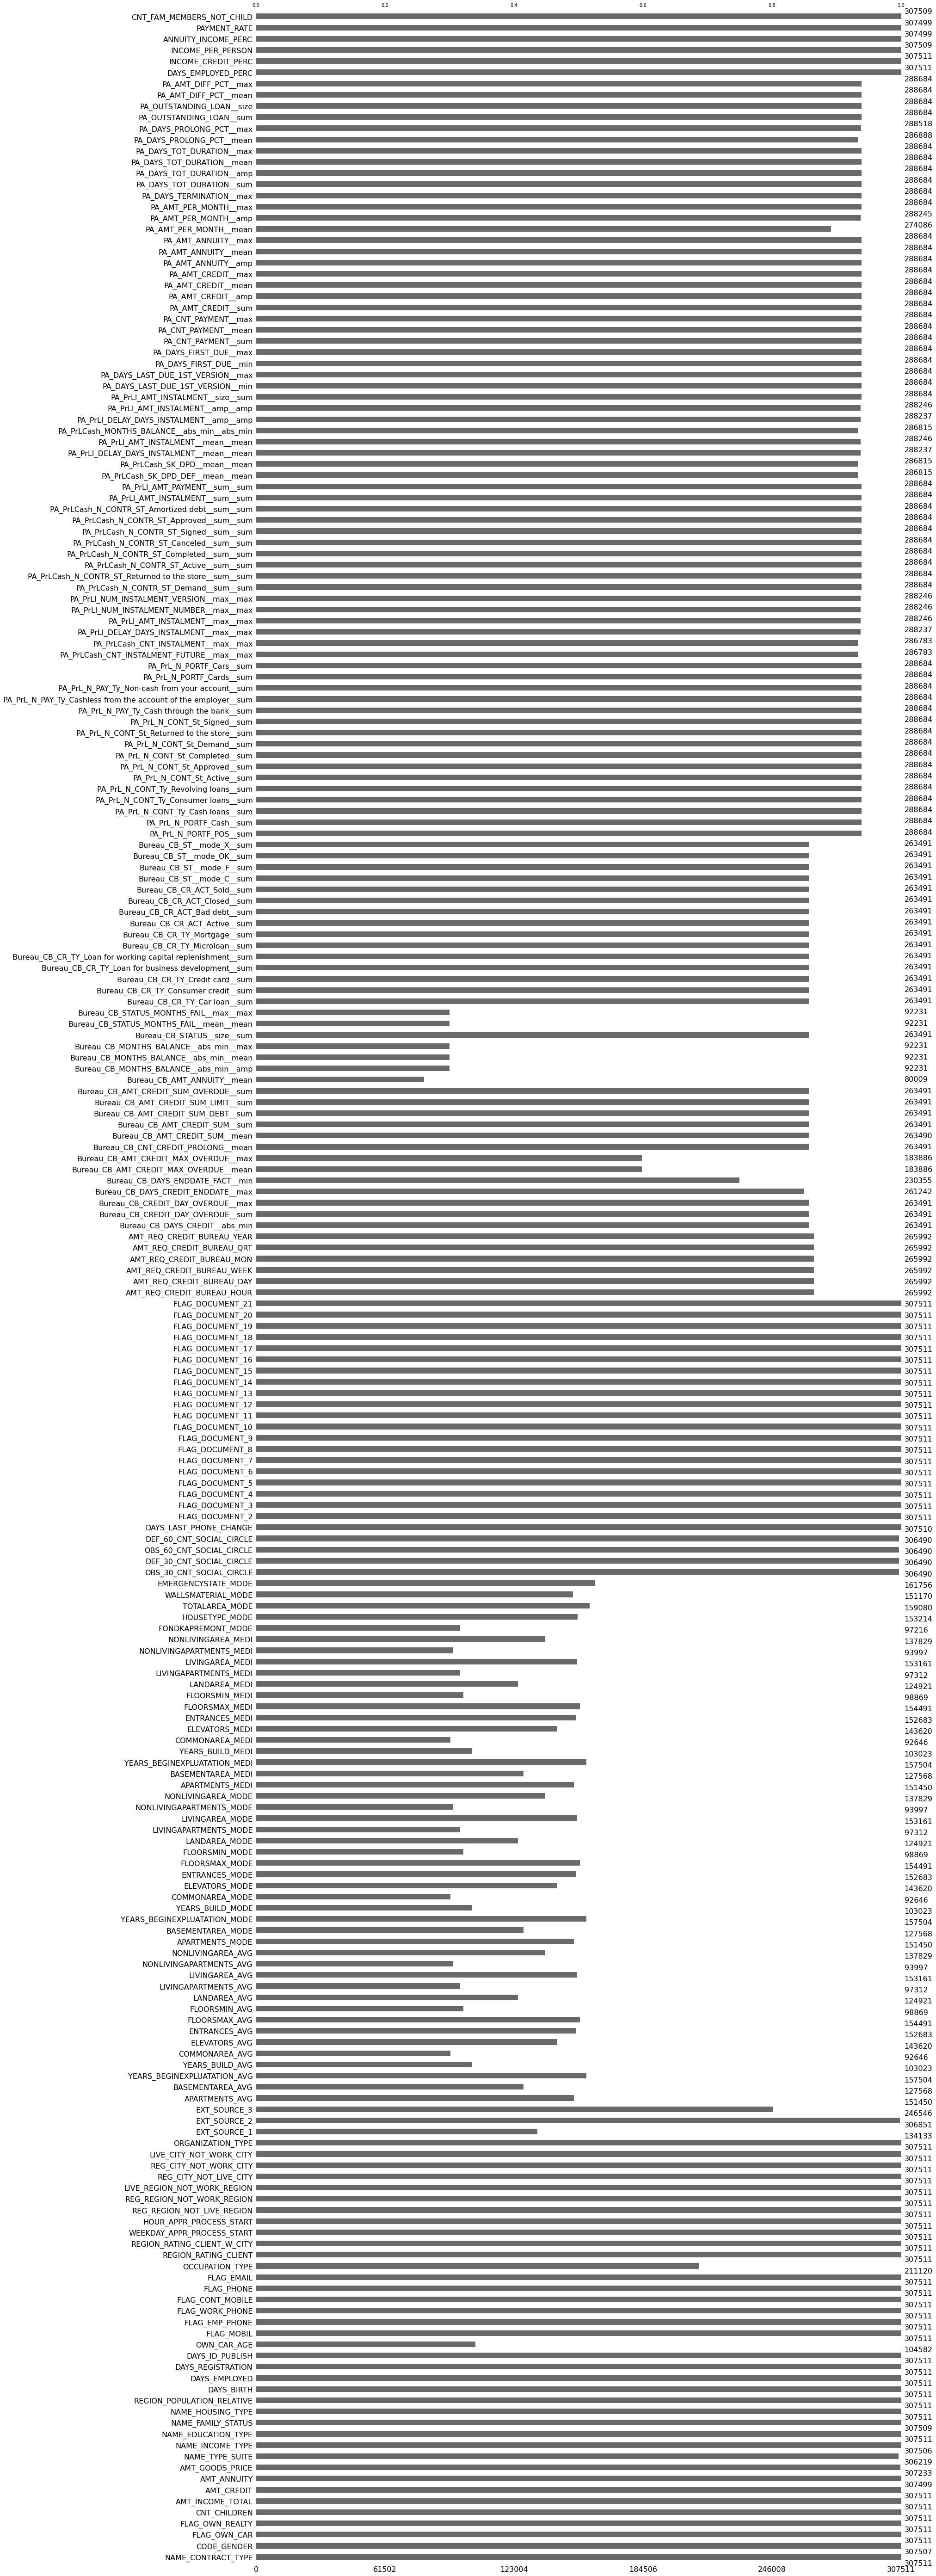

In [ ]:
import missingno as msno
msno.bar(X_train)

In [ ]:
cat_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [ ]:
len(cat_cols)

16

## Variables catégorielles :

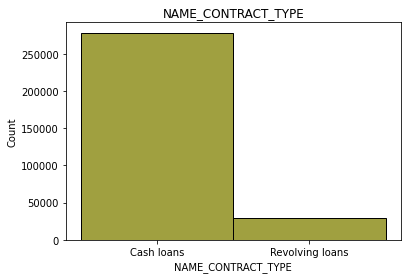

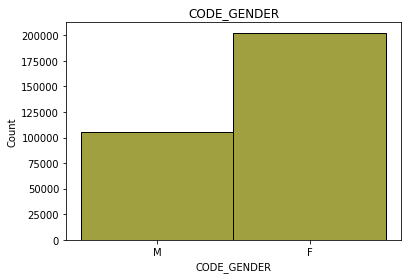

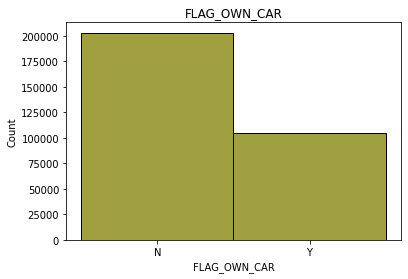

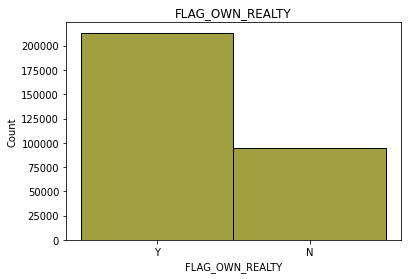

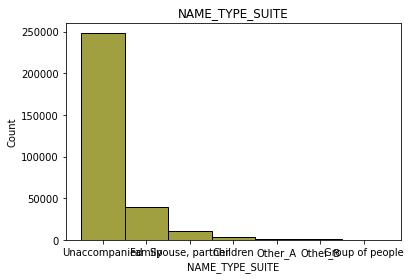

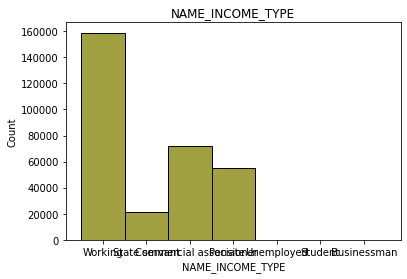

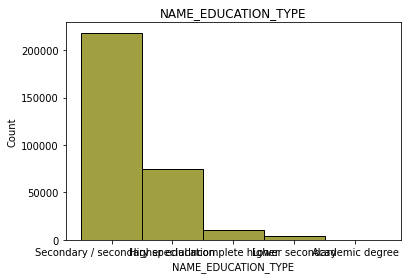

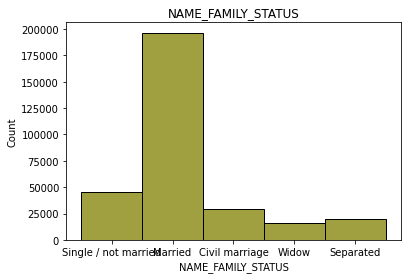

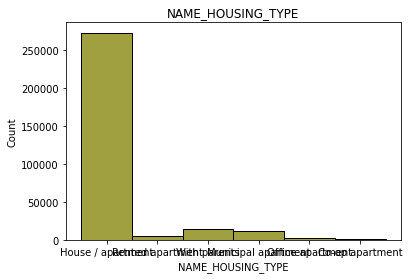

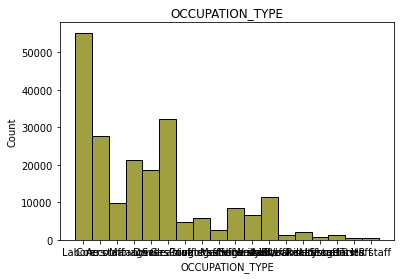

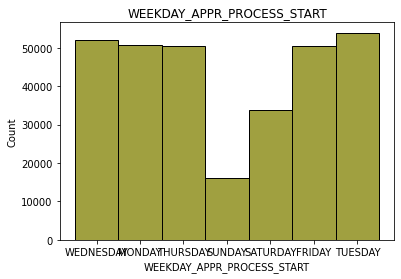

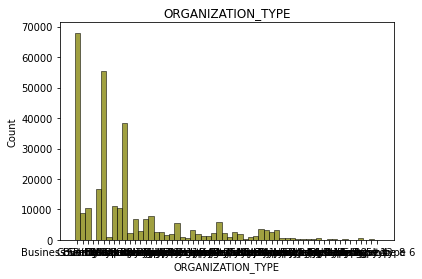

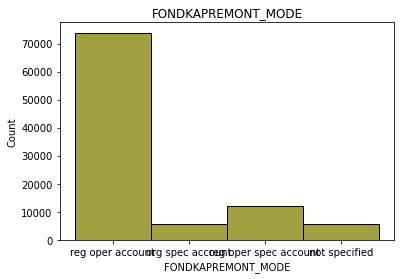

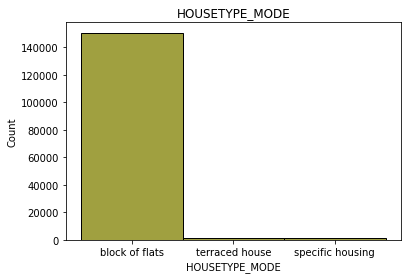

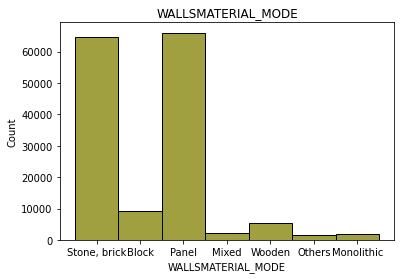

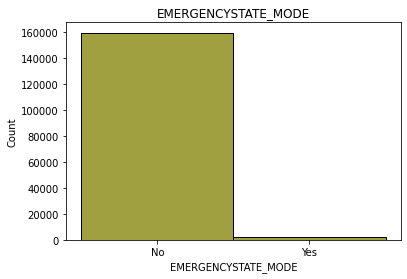

In [ ]:
for cols in cat_cols:
    sns.histplot(data= X_train, x=cols, color="olive")
    plt.title(cols)
    plt.show()

## `Variables Quantitatives`

In [ ]:
len(quant_cols)

212

In [ ]:
for cols_q in quant_cols:
    sns.histplot(data= X_train, x=cols_q, color="olive")
    plt.title(cols_q)
    plt.show()

## `Variables binaires : `

In [ ]:
len(bin_cols)

In [ ]:
for cols_b in bin_cols:
    sns.histplot(data= X_train, x=cols_b, color="olive")
    plt.title(cols_b)
    plt.show()

## `Corrélation`

In [ ]:
corr = X_train.corr()
corr

Output hidden; open in https://colab.research.google.com to view.

# `4ème Partie : Nettoyage de la base de données:`

## `Effacer variables avec beaucoup de missing values`


Certaines variables possèdent beaucoup de missing values.. On va les effacer de notre base. 

In [ ]:
def missing(X_train):
    print("Missing values in %")
    print(round((X_train.isnull().sum() * 100/ len(X_train)),2).sort_values(ascending=False))

In [ ]:
missing(X_train)

Missing values in %
Bureau_CB_AMT_ANNUITY__mean                                      73.98
Bureau_CB_STATUS_MONTHS_FAIL__mean__mean                         70.01
Bureau_CB_MONTHS_BALANCE__abs_min__amp                           70.01
Bureau_CB_MONTHS_BALANCE__abs_min__mean                          70.01
Bureau_CB_MONTHS_BALANCE__abs_min__max                           70.01
Bureau_CB_STATUS_MONTHS_FAIL__max__max                           70.01
COMMONAREA_MEDI                                                  69.87
COMMONAREA_MODE                                                  69.87
COMMONAREA_AVG                                                   69.87
NONLIVINGAPARTMENTS_MODE                                         69.43
NONLIVINGAPARTMENTS_AVG                                          69.43
NONLIVINGAPARTMENTS_MEDI                                         69.43
FONDKAPREMONT_MODE                                               68.39
LIVINGAPARTMENTS_MEDI                                    

On veut effacer les variables avec plus de 60% de "missing values"

In [ ]:
X_train_2 = X_train.drop(X_train.loc[:,list((100*(X_train.isnull().sum()/len(X_train))>=60))].columns, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
# observer le nombre de variables après avoir effacé les variables avec + de 60% de missing values 
X_train_2.shape

(307511, 181)

In [ ]:
liste_var_effacer = X_train.loc[:,list((100*(X_train.isnull().sum()/len(X_train))>=50))].columns

In [ ]:
liste_var_effacer # Variables pour effacer dans les données test

Index(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
       'Bureau_CB_AMT_ANNUITY__mean', 'Bureau_CB_MONTHS_BALANCE__abs_min__amp',
       'Bureau_CB_MONTHS_BALANCE__abs

In [ ]:
X_test_2 = X_test.drop(X_test.loc[:,liste_var_effacer].columns,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
X_test_2.shape

(48744, 181)

##  `Remplacement des données manquants`

In [ ]:
# Connaitre la quantité de variables pour chaque type

# 1. Variables catégorielles (en format string)
var_categ = X_train_2.select_dtypes(exclude=[np.number]).columns

# 2. Variables numériques: 
var_numeric = X_train_2.select_dtypes(include=[np.number]).columns

In [ ]:
print(len(var_categ), var_categ) # 13 variables strings et leurs noms

13 Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'EMERGENCYSTATE_MODE'],
      dtype='object')


In [ ]:
print(len(var_numeric), var_numeric) # 168 variables numériques 

168 Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH',
       ...
       'PA_OUTSTANDING_LOAN__sum', 'PA_OUTSTANDING_LOAN__size', 'PA_AMT_DIFF_PCT__mean',
       'PA_AMT_DIFF_PCT__max', 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON',
       'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'CNT_FAM_MEMBERS_NOT_CHILD'],
      dtype='object', length=168)


In [ ]:
# Remplacement des variables textes - méthode : MODE

for variables in var_categ:
  mode = X_train_2[variables].mode()
  X_train_2[variables] = X_train_2[variables].fillna(mode)
  X_test_2[variables] = X_test_2[variables].fillna(mode)

In [ ]:
'''
Hypothèse: Les variables numériques peuvent être des 2 types: 1 - Catégorielles (si nombre de valeurs uniques <= 20) ou 2 - Continue (si nombre de valeurs uniques >20)
Dans le premier cas, on attribue aux valeurs manquants le "mode" de chaque variable. Dans le 2ème cas on attribue aux valeurs manquants la moyenne).
'''

# 1. Variables numériques catégorielles:

# a) Identification des variables avec unique values <=20
var_num_cat = \
X_train_2[var_numeric].columns\
[X_train[var_numeric].nunique()<=20]


# b) Remplacement des valeurs manquants par la mesure "mode"

for variables in var_num_cat:
  mode = X_train_2[variables].mode()[0]
  X_train_2[variables] = X_train_2[variables].fillna(mode)
  X_test_2[variables] = X_test_2[variables].fillna(mode)

In [ ]:
# 2. Variables numériques continues:

# a) Identification des variables numériques continues:

var_num_cont = \
X_train_2[var_numeric].columns\
[X_train[var_numeric].nunique()>20]

# b) Remplacement des valeurs manquants par la moyenne:

for variables2 in var_num_cont:
  mean = X_train_2[variables2].mean()
  X_train_2[variables2] = X_train_2[variables2].fillna(mean)
  X_test_2[variables2] = X_test_2[variables2].fillna(mean)

In [ ]:
print(len(var_num_cont), len(var_num_cat))

104 64


In [ ]:
# Verification si les valeurs ont été attribuées

print(X_train_2.isnull().sum(), X_test_2.isnull().sum())

NAME_CONTRACT_TYPE                                                     0
CODE_GENDER                                                            4
FLAG_OWN_CAR                                                           0
FLAG_OWN_REALTY                                                        0
CNT_CHILDREN                                                           0
AMT_INCOME_TOTAL                                                       0
AMT_CREDIT                                                             0
AMT_ANNUITY                                                            0
AMT_GOODS_PRICE                                                        0
NAME_TYPE_SUITE                                                     1292
NAME_INCOME_TYPE                                                       5
NAME_EDUCATION_TYPE                                                    0
NAME_FAMILY_STATUS                                                     2
NAME_HOUSING_TYPE                                  

## Traitement des données :

In [ ]:
# Les variables string:
print(len(var_categ), var_categ)

13 Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'EMERGENCYSTATE_MODE'],
      dtype='object')


In [ ]:
# Comprendre leurs classes

for classes in var_categ:
  print(X_train_2[classes].value_counts())

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64
F    202448
M    105059
Name: CODE_GENDER, dtype: int64
N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64
Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Name: NAME_INCOME_TYPE, dtype: int64
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64
Married                 

In [ ]:
for classes2 in var_num_cont:
  print(X_train_2[classes2].value_counts())

135000.00    35750
112500.00    31019
157500.00    26556
180000.00    24719
90000.00     22483
             ...  
117324.00        1
64584.00         1
142897.50        1
109170.00        1
113062.50        1
Name: AMT_INCOME_TOTAL, Length: 2548, dtype: int64
450000.00     9709
675000.00     8877
225000.00     8162
180000.00     7342
270000.00     7241
              ... 
487318.50        1
630400.50        1
1875276.00       1
1395895.50       1
1391130.00       1
Name: AMT_CREDIT, Length: 5603, dtype: int64
9000.00      6385
13500.00     5514
6750.00      2279
10125.00     2035
37800.00     1602
             ... 
79902.00        1
106969.50       1
60885.00        1
59661.00        1
77809.50        1
Name: AMT_ANNUITY, Length: 13673, dtype: int64
450000.00     26022
225000.00     25282
675000.00     24962
900000.00     15416
270000.00     11428
              ...  
447606.00         1
2106000.00        1
894654.00         1
323982.00         1
743863.50         1
Name: AMT_GOODS_PRICE

`Création de variables binaires pour les variables avec nombre de classes = 2`

In [ ]:
# a) Identification des variables dummyes:
dummies_variables = \
X_train_2[var_categ].columns\
[X_train[var_categ].nunique()==2]

In [ ]:
dummies_variables

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'EMERGENCYSTATE_MODE'],
      dtype='object')

In [ ]:
# Appliquer les conditions et sauvegarder seulement variables 

# données entrainement
X_train_add_a = X_train_2[dummies_variables]
X_train_add_a = pd.get_dummies(X_train_add_a, columns = dummies_variables)
X_train_add_a.info()

# données test
X_test_add_a = X_test_2[dummies_variables]
X_test_add_a = pd.get_dummies(X_test_add_a, columns = dummies_variables)
X_test_add_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Data columns (total 10 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   NAME_CONTRACT_TYPE_Cash loans       307511 non-null  uint8
 1   NAME_CONTRACT_TYPE_Revolving loans  307511 non-null  uint8
 2   CODE_GENDER_F                       307511 non-null  uint8
 3   CODE_GENDER_M                       307511 non-null  uint8
 4   FLAG_OWN_CAR_N                      307511 non-null  uint8
 5   FLAG_OWN_CAR_Y                      307511 non-null  uint8
 6   FLAG_OWN_REALTY_N                   307511 non-null  uint8
 7   FLAG_OWN_REALTY_Y                   307511 non-null  uint8
 8   EMERGENCYSTATE_MODE_No              307511 non-null  uint8
 9   EMERGENCYSTATE_MODE_Yes             307511 non-null  uint8
dtypes: uint8(10)
memory usage: 5.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 45

In [ ]:
c = X_train_add_a.columns

In [ ]:
for classess in c:
  print(X_train_add_a[classess].value_counts())

1    278232
0     29279
Name: NAME_CONTRACT_TYPE_Cash loans, dtype: int64
0    278232
1     29279
Name: NAME_CONTRACT_TYPE_Revolving loans, dtype: int64
1    202448
0    105063
Name: CODE_GENDER_F, dtype: int64
0    202452
1    105059
Name: CODE_GENDER_M, dtype: int64
1    202924
0    104587
Name: FLAG_OWN_CAR_N, dtype: int64
0    202924
1    104587
Name: FLAG_OWN_CAR_Y, dtype: int64
0    213312
1     94199
Name: FLAG_OWN_REALTY_N, dtype: int64
1    213312
0     94199
Name: FLAG_OWN_REALTY_Y, dtype: int64
1    159428
0    148083
Name: EMERGENCYSTATE_MODE_No, dtype: int64
0    305183
1      2328
Name: EMERGENCYSTATE_MODE_Yes, dtype: int64


In [ ]:
# Selectionner seulement les variables adaptées ou les classes = 1 :
cols = ["CODE_GENDER_M", "NAME_CONTRACT_TYPE_Cash loans", "FLAG_OWN_CAR_Y", "FLAG_OWN_REALTY_Y", "EMERGENCYSTATE_MODE_Yes" ]
X_train_add_a= X_train_add_a[cols]
X_test_add_a = X_test_add_a[cols]

# Renommer les colonnes
X_train_add_a = X_train_add_a.rename(columns={"CODE_GENDER_M": "Gender_", "NAME_CONTRACT_TYPE_Cash loans": "Name_contract_type", "FLAG_OWN_CAR_Y": "flag_own_car", "FLAG_OWN_REALTY_Y": "flag_own_realty", "EMERGENCYSTATE_MODE_Yes": "emergency_state"})
X_test_add_a = X_test_add_a.rename(columns={"CODE_GENDER_M": "Gender_", "NAME_CONTRACT_TYPE_Cash loans": "Name_contract_type", "FLAG_OWN_CAR_Y": "flag_own_car", "FLAG_OWN_REALTY_Y": "flag_own_realty", "EMERGENCYSTATE_MODE_Yes": "emergency_state"})

In [ ]:
X_train_add_a.info()
X_test_add_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   Gender_             307511 non-null  uint8
 1   Name_contract_type  307511 non-null  uint8
 2   flag_own_car        307511 non-null  uint8
 3   flag_own_realty     307511 non-null  uint8
 4   emergency_state     307511 non-null  uint8
dtypes: uint8(5)
memory usage: 3.8 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Gender_             48744 non-null  uint8
 1   Name_contract_type  48744 non-null  uint8
 2   flag_own_car        48744 non-null  uint8
 3   flag_own_realty     48744 non-null  uint8
 4   emergency_state     48744 non-null  uint8
dtypes: uint8(5)
memory usage: 618.8 KB


`Création des variables one_hot_encoding pour les variables avec le nombre de classes supérieur à 3`

In [ ]:
cat_variab = \
X_train_2[var_categ].columns\
[X_train[var_categ].nunique()>2]

In [ ]:
cat_variab

Index(['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

In [ ]:
print(len(cat_variab))

8


In [ ]:
# Prendre en compte seulement les "cat_variab"

X_train_add_b = X_train_2[cat_variab]
X_test_add_b = X_test_2[cat_variab]

In [ ]:
X_train_add_b = pd.get_dummies(X_train_add_b, columns = cat_variab)

In [ ]:
X_test_add_b = pd.get_dummies(X_test_add_b, columns = cat_variab)

### `Concatener les variables traitées dans les bons datasets`

#### `Données entrainement`

In [ ]:
X_train_2.info()
X_test_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 181 entries, NAME_CONTRACT_TYPE to CNT_FAM_MEMBERS_NOT_CHILD
dtypes: float64(129), int64(39), object(13)
memory usage: 427.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Columns: 181 entries, NAME_CONTRACT_TYPE to CNT_FAM_MEMBERS_NOT_CHILD
dtypes: float64(129), int64(39), object(13)
memory usage: 67.7+ MB


In [ ]:
X_train_add_a.info()
X_test_add_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   Gender_             307511 non-null  uint8
 1   Name_contract_type  307511 non-null  uint8
 2   flag_own_car        307511 non-null  uint8
 3   flag_own_realty     307511 non-null  uint8
 4   emergency_state     307511 non-null  uint8
dtypes: uint8(5)
memory usage: 3.8 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Gender_             48744 non-null  uint8
 1   Name_contract_type  48744 non-null  uint8
 2   flag_own_car        48744 non-null  uint8
 3   flag_own_realty     48744 non-null  uint8
 4   emergency_state     48744 non-null  uint8
dtypes: uint8(5)
memory usage: 618.8 KB


In [ ]:
X_train_add_b.info()
X_test_add_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 113 entries, NAME_TYPE_SUITE_Children to ORGANIZATION_TYPE_XNA
dtypes: uint8(113)
memory usage: 35.5 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Columns: 113 entries, NAME_TYPE_SUITE_Children to ORGANIZATION_TYPE_XNA
dtypes: uint8(113)
memory usage: 5.6 MB


In [ ]:
# Rassembler les nouvelles variables dans le dataset 
X_train = X_train_2.merge(X_train_add_a, left_index=True, right_index=True)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 186 entries, NAME_CONTRACT_TYPE to emergency_state
dtypes: float64(129), int64(39), object(13), uint8(5)
memory usage: 436.5+ MB


In [ ]:
X_train = X_train.merge(X_train_add_b, left_index=True, right_index=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 299 entries, NAME_CONTRACT_TYPE to ORGANIZATION_TYPE_XNA
dtypes: float64(129), int64(39), object(13), uint8(118)
memory usage: 469.7+ MB


In [ ]:
# Exclure variables strings:
# 1. Variables catégorielles (en format string)
var_categ = X_train.select_dtypes(exclude=[np.number]).columns

X_train = X_train.drop(X_train.loc[:,var_categ].columns,1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 286 entries, CNT_CHILDREN to ORGANIZATION_TYPE_XNA
dtypes: float64(129), int64(157)
memory usage: 673.3 MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


#### `Données test :`

In [ ]:
# Rassembler les nouvelles variables dans le dataset 
X_test = X_test_2.merge(X_test_add_a, left_index=True, right_index=True)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Columns: 186 entries, NAME_CONTRACT_TYPE to emergency_state
dtypes: float64(129), int64(39), object(13), uint8(5)
memory usage: 68.9+ MB


In [ ]:
X_test = X_test.merge(X_test_add_b, left_index=True, right_index=True)

In [ ]:
# Exclure variables strings:
X_test = X_test.drop(X_test.loc[:,var_categ].columns,1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Columns: 286 entries, CNT_CHILDREN to ORGANIZATION_TYPE_XNA
dtypes: float64(129), int64(157)
memory usage: 106.7 MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


# `5ème Partie: Sauvegarde de données `

In [ ]:
X_test.to_csv('drive/My Drive/Projet_7/X_test.csv')
X_train.to_csv('drive/My Drive/Projet_7/X_train.csv')
y_train.to_csv('drive/My Drive/Projet_7/y_train.csv')

In [ ]:
X_test.info()
X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Columns: 286 entries, CNT_CHILDREN to ORGANIZATION_TYPE_XNA
dtypes: float64(129), int64(157)
memory usage: 106.7 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 286 entries, CNT_CHILDREN to ORGANIZATION_TYPE_XNA
dtypes: float64(129), int64(157)
memory usage: 673.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   TARGET  307511 non-null  int64
dtypes: int64(1)
memory usage: 4.7 MB
